# NAME : RAVI KAKAIYA
# ROLL NO. : 21EE64R06
# ASSIGNMENT : 2

In [22]:
!pip install piqa
!pip install torchgeometry

You should consider upgrading via the 'C:\Users\ravij\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\ravij\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import argparse
import os
import numpy as np 
import math
import itertools
from piqa import SSIM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision import datasets
from skimage.metrics import structural_similarity as ssim
import torchgeometry as tgm 
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#lOADING DATA

def load_data(data_path='data/'):
    print('loading data!')
    train_batch_size = 64
    valid_batch_size = 64
    train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(data_path, train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=train_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(data_path, train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
                ])),
            batch_size=valid_batch_size, shuffle=False)
    return train_loader, test_loader

In [3]:
#SETTING HYPERPARAMETERS

n_epochs = 100 #number of epochs of training
batch_size = 64
lr1 = 0.0001 #learning rate for AE
lr2 = 0.00005 #Learning rate for Descriminator
b1 = 0.5 #Decay rate 
b2 = 0.999 #Decay rate
latent_dim = 2 
img_size = 28 
img_dir = 'image_basic'
channels = 1

# config cuda
cuda = torch.cuda.is_available()
img_shape = (channels, img_size, img_size)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [4]:
# DEFINING NETWORKS

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 1000),
            nn.ReLU(),
            nn.Linear(1000, latent_dim)
        )

        self.mu = nn.Linear(1000, latent_dim)
        self.logvar = nn.Linear(1000, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        # mu = self.mu(x)
        # logvar = self.logvar(x)
        # z = reparameterization(mu, logvar)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, int(np.prod(img_shape))),
            nn.Sigmoid(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [5]:
# DEFINING MODEL, BCE LOSS, OPTIMIZER

# data
train_labeled_loader = load_data('data/')[1]

# define model
# 1) generator
encoder = Encoder()
decoder = Decoder()
# 2) discriminator
discriminator = Discriminator()

# loss BCE
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.BCELoss()

# optimizer
optimizer_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr1, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr2, betas=(b1, b2))

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    reconstruction_loss.cuda()


loading data!


In [6]:
# Training (with BCELoss):
def sample_image(x,fake_z , n_row, epoch, img_dir):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    
    # z = Variable(Tensor(np.random.normal(0,1,(n_row**2, latent_dim))))
    generated_imgs = decoder(fake_z)
    save_image(generated_imgs.data, os.path.join(img_dir, "%depoch.png" % epoch), nrow = n_row, normalize = True)
    save_image(x, os.path.join(img_dir, "%dgiven.png" % epoch), nrow = n_row, normalize = True)

# Training phase
R_Loss1 = [];
D_Loss1 = [];
ep1 = [];
accuracy1 = [];
for epoch in range(n_epochs):
    for i, (x, idx) in enumerate(train_labeled_loader):

        valid = Variable(Tensor(x.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(x.shape[0], 1).fill_(0.0), requires_grad=False)
        if cuda:
            x = x.cuda()
        
        # 1) reconstruction + generator loss
        optimizer_G.zero_grad()
        fake_z = encoder(x)
        decoded_x = decoder(fake_z)
        validity_fake_z = discriminator(fake_z)
        #for BCE lOSS
        G_loss = 0.001*adversarial_loss(validity_fake_z, valid) + 0.999*reconstruction_loss(decoded_x, x)
        G_loss.backward()
        optimizer_G.step()

        # 2) discriminator loss
        optimizer_D.zero_grad()
        real_z = Variable(Tensor(np.random.normal(0,1,(x.shape[0], latent_dim))))
        
        #for MSE and BCE loss
        real_loss = adversarial_loss(discriminator(real_z), valid)
        fake_loss = adversarial_loss(discriminator(fake_z.detach()), fake)
        D_loss = 0.5*(real_loss + fake_loss)
        D_loss.backward()
        optimizer_D.step()
        R_Loss1.append(G_loss.item())
        D_Loss1.append(D_loss.item())
        accuracy1.append(1-D_loss.item())
        ep1.append(epoch)
    # print loss
    print(
            "[Epoch %d/%d] [Reconstruction loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, G_loss.item(), D_loss.item())
         )
        
    sample_image(x,fake_z , n_row = 3, epoch=epoch, img_dir=img_dir)

[Epoch 0/100] [Reconstruction loss: -23.365231] [Discriminator loss: 0.195361]
[Epoch 1/100] [Reconstruction loss: -26.768616] [Discriminator loss: 0.146369]
[Epoch 2/100] [Reconstruction loss: -29.115585] [Discriminator loss: 0.092434]
[Epoch 3/100] [Reconstruction loss: -31.521441] [Discriminator loss: 0.084829]
[Epoch 4/100] [Reconstruction loss: -33.566425] [Discriminator loss: 0.061997]
[Epoch 5/100] [Reconstruction loss: -35.089031] [Discriminator loss: 0.058278]
[Epoch 6/100] [Reconstruction loss: -35.635822] [Discriminator loss: 0.046548]
[Epoch 7/100] [Reconstruction loss: -36.364990] [Discriminator loss: 0.047127]
[Epoch 8/100] [Reconstruction loss: -36.881851] [Discriminator loss: 0.035019]
[Epoch 9/100] [Reconstruction loss: -37.242817] [Discriminator loss: 0.035943]
[Epoch 10/100] [Reconstruction loss: -37.677792] [Discriminator loss: 0.027746]
[Epoch 11/100] [Reconstruction loss: -38.040997] [Discriminator loss: 0.024263]
[Epoch 12/100] [Reconstruction loss: -38.358276] [

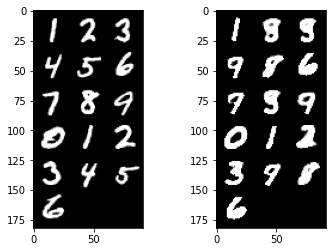

In [11]:
#PART : 1 
im = Image.open("image_basic\99given.png")
im1 = Image.open("image_basic\99epoch.png")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(im)
axarr[1].imshow(im1)

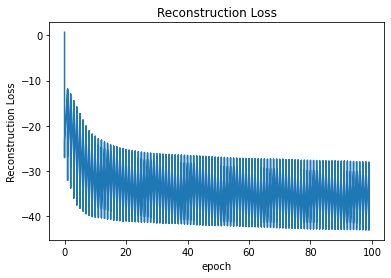

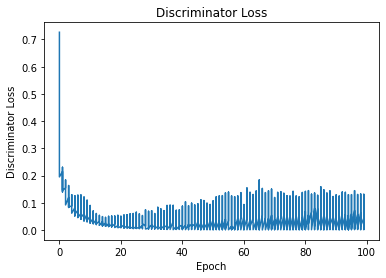

In [12]:
#PART : 2
plt.plot(ep1,R_Loss1)
plt.xlabel("epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Reconstruction Loss")
plt.show()
plt.plot(ep1,D_Loss1)
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss")
plt.show()

# Comment On the Graphs :
    We are observing that Reconstruction loss and discriminator loss are both having a decaying nature along with some bumping structure. Since here our encoder decoder and discriminator all of the networks are getting trained. So while training we can observe the convergence will be such that there is a swing in between two points and that will Couse the bumping structure in loss graph.

# PART : 3
# Training Process of the Vanilla Adversarial Autoencoder

    1) Do a forward path through the encoder/decoder part

    2)compute the reconstruction loss and update the parameteres of the encoder Q and decoder P networks.

    3) Create a latent representation z = Q(x) and take a sample z’ from the prior p(z), run each one through the discriminator and compute the score assigned to each (D(z) and D(z’)).

    4) Compute the loss in the discriminator as and backpropagate it through the discriminator network and the encoder  to update its weights. 


In [13]:
# DEFINING MODEL,MSE LOSS, OPTIMIZER

# data
train_labeled_loader = load_data('data/')[1]

# define model
# 1) generator
encoder = Encoder()
decoder = Decoder()
# 2) discriminator
discriminator = Discriminator()

# # loss MSE
adversarial_loss = nn.MSELoss()
reconstruction_loss = nn.MSELoss()

# optimizer
optimizer_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr1, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr2, betas=(b1, b2))

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    reconstruction_loss.cuda()


loading data!


In [14]:
# Training USING MSE Loss
R_Loss2 = [];
D_Loss2 = [];
ep2 = [];
accuracy2 = [];
for epoch in range(n_epochs):
    for i, (x, idx) in enumerate(train_labeled_loader):

        valid = Variable(Tensor(x.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(x.shape[0], 1).fill_(0.0), requires_grad=False)
        if cuda:
            x = x.cuda()
        
        # 1) reconstruction + generator loss
        optimizer_G.zero_grad()
        fake_z = encoder(x)
        decoded_x = decoder(fake_z)
        validity_fake_z = discriminator(fake_z)
        
        #for MSE Loss
        G_loss = 0.001*adversarial_loss(validity_fake_z, valid) + 0.999*reconstruction_loss(decoded_x, x)
        G_loss.backward()
        optimizer_G.step()

        # 2) discriminator loss
        optimizer_D.zero_grad()
        real_z = Variable(Tensor(np.random.normal(0,1,(x.shape[0], latent_dim))))
    
        #for MSE loss
        real_loss = adversarial_loss(discriminator(real_z), valid)
        fake_loss = adversarial_loss(discriminator(fake_z.detach()), fake)
        D_loss = 0.5*(real_loss + fake_loss)
        D_loss.backward()
        optimizer_D.step()
        R_Loss2.append(G_loss.item())
        D_Loss2.append(D_loss.item())
        accuracy2.append(1-D_loss.item())
        ep2.append(epoch)
    # print loss
    print(
            "[Epoch %d/%d] [Reconstruction loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, G_loss.item(), D_loss.item())
         )
        
    sample_image(x,fake_z , n_row = 3, epoch=epoch, img_dir=img_dir)

[Epoch 0/100] [Reconstruction loss: 0.815821] [Discriminator loss: 0.071842]
[Epoch 1/100] [Reconstruction loss: 0.800283] [Discriminator loss: 0.050006]
[Epoch 2/100] [Reconstruction loss: 0.790172] [Discriminator loss: 0.044130]
[Epoch 3/100] [Reconstruction loss: 0.782532] [Discriminator loss: 0.030679]
[Epoch 4/100] [Reconstruction loss: 0.775453] [Discriminator loss: 0.024474]
[Epoch 5/100] [Reconstruction loss: 0.770483] [Discriminator loss: 0.017621]
[Epoch 6/100] [Reconstruction loss: 0.768216] [Discriminator loss: 0.015073]
[Epoch 7/100] [Reconstruction loss: 0.766286] [Discriminator loss: 0.012348]
[Epoch 8/100] [Reconstruction loss: 0.764549] [Discriminator loss: 0.012310]
[Epoch 9/100] [Reconstruction loss: 0.762831] [Discriminator loss: 0.008142]
[Epoch 10/100] [Reconstruction loss: 0.761381] [Discriminator loss: 0.009106]
[Epoch 11/100] [Reconstruction loss: 0.760117] [Discriminator loss: 0.009315]
[Epoch 12/100] [Reconstruction loss: 0.759575] [Discriminator loss: 0.0063

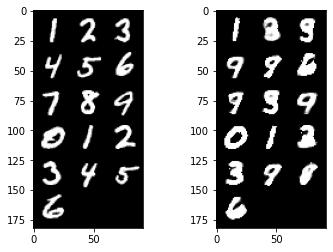

In [15]:
#PART : 1 
im = Image.open("image_basic\99given.png")
im1 = Image.open("image_basic\99epoch.png")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(im)
axarr[1].imshow(im1)

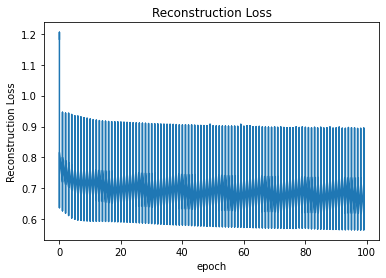

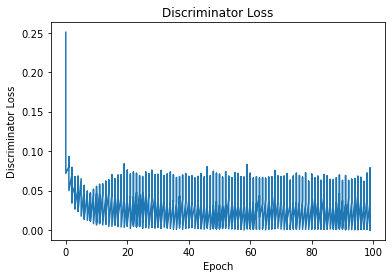

In [16]:
#PART : 2
plt.plot(ep2,R_Loss2)
plt.xlabel("epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Reconstruction Loss")
plt.show()
plt.plot(ep2,D_Loss2)
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss")
plt.show()

In [17]:
# DEFINING MODEL,SSIM LOSS, OPTIMIZER

# data
train_labeled_loader = load_data('data/')[1]

# define model
# 1) generator
encoder = Encoder()
decoder = Decoder()
# 2) discriminator
discriminator = Discriminator()


# loss SSIM

adversarial_loss = tgm.losses.SSIM(5, reduction='mean').cuda()
reconstruction_loss = tgm.losses.SSIM(5, reduction='mean').cuda()

# optimizer
optimizer_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr1, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr2, betas=(b1, b2))

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    reconstruction_loss.cuda()

loading data!


In [18]:
# Training USING SSIM Loss
R_Loss3 = [];
D_Loss3 = [];
ep3 = [];
accuracy3 = [];
for epoch in range(n_epochs):
    for i, (x, idx) in enumerate(train_labeled_loader):

        valid = Variable(Tensor(x.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(x.shape[0], 1).fill_(0.0), requires_grad=False)
        if cuda:
            x = x.cuda()
        
        # 1) reconstruction + generator loss
        optimizer_G.zero_grad()
        fake_z = encoder(x)
        decoded_x = decoder(fake_z)
        validity_fake_z = discriminator(fake_z)
        #for SSIM loss
        G_loss = 0.001*(adversarial_loss(validity_fake_z.view(1,1,fake_z.shape[0],1), valid.view(1,1,fake_z.shape[0],1))) + 0.999*(reconstruction_loss(decoded_x, x))
        G_loss.backward()
        optimizer_G.step()

        # 2) discriminator loss
        optimizer_D.zero_grad()
        real_z = Variable(Tensor(np.random.normal(0,1,(x.shape[0], latent_dim))))
        #for SSIM loss
        real_loss = adversarial_loss(discriminator(real_z).view(1,1,fake_z.shape[0],1), valid.view(1,1,fake_z.shape[0],1))
        fake_loss = adversarial_loss(discriminator(fake_z.detach()).view(1,1,fake_z.shape[0],1), fake.view(1,1,fake_z.shape[0],1))
        D_loss = 0.5*(real_loss + fake_loss)
        D_loss.backward()
        optimizer_D.step()
        R_Loss3.append(G_loss.item())
        D_Loss3.append(D_loss.item())
        accuracy3.append(1-D_loss.item())
        ep3.append(epoch)
    # print loss
    print(
            "[Epoch %d/%d] [Reconstruction loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, G_loss.item(), D_loss.item())
         )
        
    sample_image(x,fake_z , n_row = 3, epoch=epoch, img_dir=img_dir)

[Epoch 0/100] [Reconstruction loss: 0.353888] [Discriminator loss: 0.274442]
[Epoch 1/100] [Reconstruction loss: 0.353410] [Discriminator loss: 0.260345]
[Epoch 2/100] [Reconstruction loss: 0.352928] [Discriminator loss: 0.255891]
[Epoch 3/100] [Reconstruction loss: 0.352033] [Discriminator loss: 0.253086]
[Epoch 4/100] [Reconstruction loss: 0.351050] [Discriminator loss: 0.253537]
[Epoch 5/100] [Reconstruction loss: 0.349542] [Discriminator loss: 0.252190]
[Epoch 6/100] [Reconstruction loss: 0.347616] [Discriminator loss: 0.251015]
[Epoch 7/100] [Reconstruction loss: 0.346762] [Discriminator loss: 0.251437]
[Epoch 8/100] [Reconstruction loss: 0.346323] [Discriminator loss: 0.250971]
[Epoch 9/100] [Reconstruction loss: 0.346160] [Discriminator loss: 0.251044]
[Epoch 10/100] [Reconstruction loss: 0.345999] [Discriminator loss: 0.250639]
[Epoch 11/100] [Reconstruction loss: 0.345784] [Discriminator loss: 0.250580]
[Epoch 12/100] [Reconstruction loss: 0.345575] [Discriminator loss: 0.2505

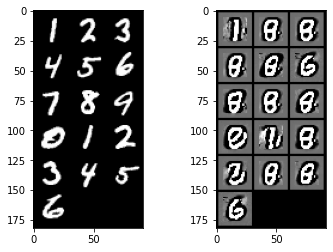

In [19]:
#PART : 1 
im = Image.open("image_basic\99given.png")
im1 = Image.open("image_basic\99epoch.png")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(im)
axarr[1].imshow(im1)

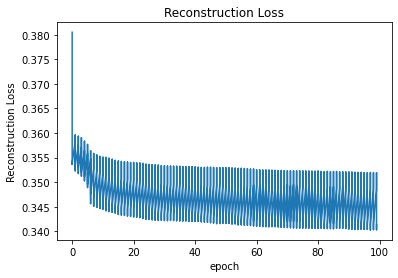

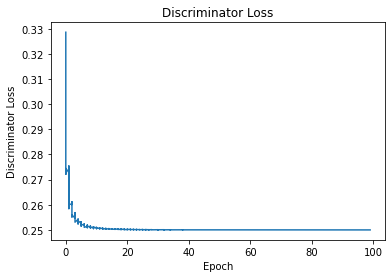

In [20]:
#PART : 2
plt.plot(ep3,R_Loss3)
plt.xlabel("epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Reconstruction Loss")
plt.show()
plt.plot(ep3,D_Loss3)
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss")
plt.show()

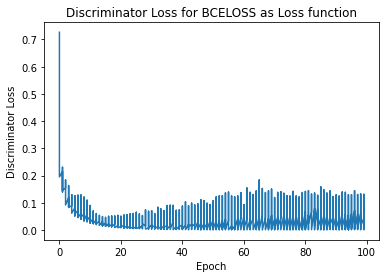

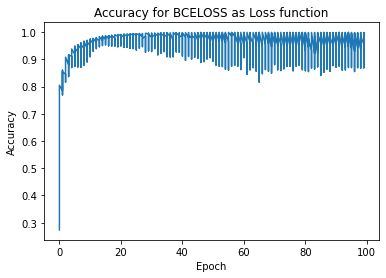

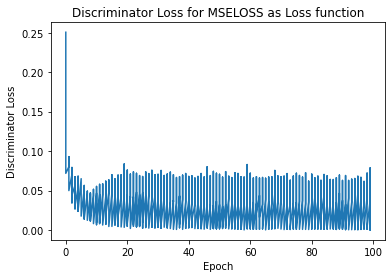

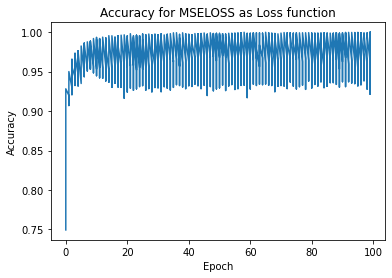

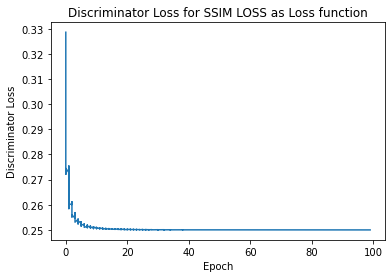

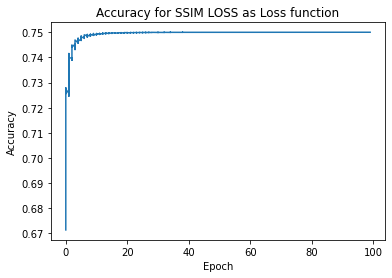

In [21]:
# PART 4 :
#BCE LOSS
plt.plot(ep1,D_Loss1)
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss for BCELOSS as Loss function")
plt.show()
plt.plot(ep1,accuracy1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy for BCELOSS as Loss function")
plt.show()

#MSE LOSS
plt.plot(ep2,D_Loss2)
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss for MSELOSS as Loss function")
plt.show()
plt.plot(ep2,accuracy2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy for MSELOSS as Loss function")
plt.show()

#SSIM LOSS
plt.plot(ep3,D_Loss3)
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss for SSIM LOSS as Loss function")
plt.show()
plt.plot(ep3,accuracy3)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy for SSIM LOSS as Loss function")
plt.show()

 # Comment on the Loss function
 
     We observe that the Loss for BCE is having less variation as compared to other Loss function. And Gives more accurate convergence as compared to other Losses. We observe that SSIM loss is having less variation but convergence is not accurate. So, Most suggested is Binary Cross entropy Loss.  